In [1]:
import os
import pandas
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [114]:
# Custom Dataset
class DetectDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        
        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        label = self._load_label(label_path)
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    
    # Helper function to get label from images
    def _load_label(self, label_path):
        # parse the label path and read files
        with open(label_path, 'r') as file:
            boxes = []
            for line in file.readlines():
                # Grab label variables from file
                class_id, x_center, y_center, width, height = map(float, line.strip().split()) # returns list of float from split line
                boxes.append([class_id, x_center, y_center, width, height])
        return torch.tensor(boxes)

In [100]:
# Variable Length Data: Each image can have a different number of bounding boxes. 
# The default collate_fn tries to stack everything into tensors, which fails if they have different shapes.

# Stack images into tensors but not targets to avoid this conflict
def collate_fn(batch):
    images = []
    targets = []
    for sample in batch:
        images.append(sample[0])
        targets.append(sample[1])
    images = torch.stack(images, dim=0)
    return images, targets

In [101]:
# class IDs
classes = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [102]:
train_labels_dir = "../data/VehiclesDetectionDataset/train/labels/"
train_img_dir = "../data/VehiclesDetectionDataset/train/images/"
test_labels_dir = "../data/VehiclesDetectionDataset/test/labels/"
test_img_dir = "../data/VehiclesDetectionDataset/test/images/"

In [115]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# load images dataset
trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [116]:
# Calculate mean and std of image dataset
sum_ = torch.zeros(3)
sum_squared = torch.zeros(3)
num_images = 0

for images, _ in trainloader:
    sum_ += images.sum(dim=[0, 2, 3])
    sum_squared += (images ** 2).sum(dim=[0, 2, 3])
    num_images += images.size(0)

mean = sum_ / (num_images * images.size(2) * images.size(3))
std = (sum_squared / (num_images * images.size(2) * images.size(3)) - mean ** 2).sqrt()

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4525, 0.4424, 0.4260])
Std: tensor([0.2787, 0.2777, 0.2892])


In [117]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [118]:
norm_trainset = DetectDataset(train_labels_dir, train_img_dir, transform=transform)
norm_trainloader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [119]:
testset = DetectDataset(test_labels_dir, test_img_dir, transform=transform)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

In [120]:
train_features, train_labels = next(iter(trainloader))

In [121]:
train_features

tensor([[[[0.8235, 0.8235, 0.8235,  ..., 0.8980, 0.8471, 0.8078],
          [0.8235, 0.8235, 0.8235,  ..., 0.8118, 0.8902, 0.9686],
          [0.8235, 0.8235, 0.8235,  ..., 0.9333, 0.9451, 0.9373],
          ...,
          [0.9412, 0.9294, 0.9294,  ..., 0.8078, 0.8118, 0.8039],
          [0.9608, 0.9529, 0.9490,  ..., 0.8078, 0.8118, 0.8078],
          [0.9647, 0.9608, 0.9569,  ..., 0.8078, 0.8118, 0.8039]],

         [[0.8431, 0.8431, 0.8431,  ..., 0.9176, 0.8667, 0.8275],
          [0.8431, 0.8431, 0.8431,  ..., 0.8314, 0.9098, 0.9882],
          [0.8431, 0.8431, 0.8431,  ..., 0.9529, 0.9647, 0.9569],
          ...,
          [0.6941, 0.6941, 0.6941,  ..., 0.5490, 0.5529, 0.5451],
          [0.6941, 0.6941, 0.6902,  ..., 0.5490, 0.5529, 0.5490],
          [0.6941, 0.6902, 0.6941,  ..., 0.5490, 0.5529, 0.5451]],

         [[0.9176, 0.9176, 0.9176,  ..., 0.9294, 0.8784, 0.8392],
          [0.9176, 0.9176, 0.9176,  ..., 0.8431, 0.9216, 1.0000],
          [0.9176, 0.9176, 0.9176,  ..., 0

In [122]:
train_labels

[tensor([[4.0000, 0.4772, 0.4483, 0.8978, 0.8834]]),
 tensor([[1.0000, 0.4940, 0.5745, 0.6851, 0.6250]]),
 tensor([[1.0000, 0.3017, 0.5288, 0.4387, 0.4688],
         [1.0000, 0.7320, 0.5108, 0.4736, 0.4904]]),
 tensor([[1.0000, 0.4724, 0.5589, 0.5853, 0.6130],
         [1.0000, 0.8822, 0.3702, 0.2308, 0.7224]]),
 tensor([[2.0000, 0.4988, 0.4447, 0.9976, 0.6587]]),
 tensor([[2.0000, 0.0192, 0.7224, 0.0216, 0.0228],
         [2.0000, 0.0312, 0.7260, 0.0445, 0.0276],
         [2.0000, 0.0517, 0.7103, 0.0240, 0.0204],
         [2.0000, 0.1923, 0.7572, 0.2873, 0.1082],
         [2.0000, 0.9519, 0.6923, 0.0204, 0.0276],
         [2.0000, 0.9736, 0.6935, 0.0228, 0.0240]]),
 tensor([[2.0000, 0.1190, 0.2103, 0.2380, 0.3522],
         [2.0000, 0.1731, 0.0974, 0.1478, 0.1827],
         [2.0000, 0.5397, 0.5000, 0.7921, 0.9988]]),
 tensor([[2.0000, 0.6418, 0.7428, 0.6923, 0.3822],
         [2.0000, 0.2464, 0.6647, 0.4303, 0.2921],
         [2.0000, 0.4856, 0.4399, 0.0168, 0.0108]]),
 tensor([[0.000

Class ID: tensor([4.0000, 0.4772, 0.4483, 0.8978, 0.8834])
Box Coordinates: 4.0
Box Coordinates: 0.4771634638309479
Box Coordinates: 0.4483173191547394
Box Coordinates: 0.8978365659713745
Box Coordinates: 0.8834134340286255
torch.Size([416, 416, 3])


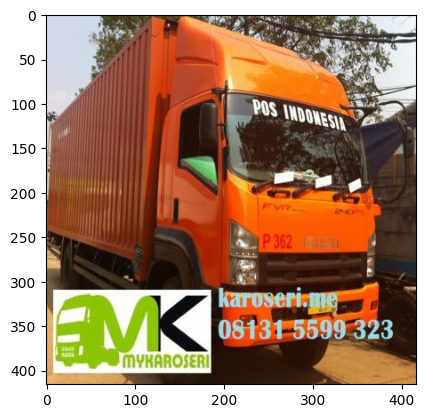

In [128]:
print(f"Class ID: {train_labels[0][0]}")
for box in train_labels[0][0]: print(f"Box Coordinates: {box}")
img = train_features[0]
img = img.permute(1, 2, 0)
print(img.shape)
plt.imshow(img)
plt.show()

In [129]:
# Convert tensor image to correct openCV image format
def tensor_to_cv2_image(tensor):
    # Convert GPU tensor to CPU based
    image = tensor.cpu().numpy() 
    image = (image * 255) # convert to unnormalized pixel values
    image = np.ascontiguousarray(image, np.uint8)
    return image

# Draw boxes on image
def draw_boxes(image, boxes, labels):
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = map(int, box)
        cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv.putText(image, str(int(label)), (x_min, y_min - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

In [130]:
# Convert image tensor to openCV image
image = tensor_to_cv2_image(img)
print("Image Type:", image.shape)

target = train_labels[0]
boxes = target['boxes']
labels = target['labels']

# Draw box on image
image = draw_boxes(image, boxes, labels)

Image Type: (416, 416, 3)


IndexError: too many indices for tensor of dimension 2

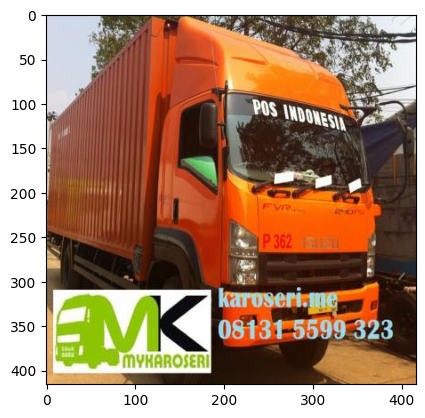

In [131]:
plt.imshow(image)

# BUG!!!
- Box coordinates are incorrect most likely due to the many transformations of the images

In [ ]:
# SAVE FOR LATER
    # Convert normalized coordinates to pixel coordinates
    # x_center *= image.width
    # y_center *= image.height
    # width *= image.width
    # height *= image.height
    
    # # Calculate bounding box corners
    # x_min = x_center - width / 2
    # y_min = y_center - height / 2
    # x_max = x_center + width / 2
    # y_max = y_center + height / 2
    
    # boxes.append([x_min, y_min, x_max, y_max])